# ST>A | Special Topics in Astrodynamics | ae4889

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras_visualizer import visualizer
from IPython.core.display import Image, display

print(f"tensorflow version: {tf.__version__}")
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(precision=4, suppress=True)

JULIAN_DAY = 86400.0
launch_window22 = 8304.5 * JULIAN_DAY

departure_range = np.array([-25, 24]) * JULIAN_DAY + launch_window22
arrival_range = np.array([-25 + 60, 24 + 449]) * JULIAN_DAY + launch_window22
time_of_flight_range = arrival_range - departure_range

raw_data = np.loadtxt('Output.txt', skiprows=1, delimiter=',')
time_of_flight = raw_data[:, 1] - raw_data[:, 0]

raw_data = np.vstack((raw_data[:, 0], time_of_flight, raw_data[:, 1], raw_data[:, 2], raw_data[:, 3])).T

tensorflow version: 2.0.0


In [2]:
raw_data.shape

(100000, 5)

In [3]:
column_names = ['Departure time [s]', 'Time of flight [s]', 'Arrival time [s]', '∆V_1 [m/s]', '∆V_2 [m/s]']
raw_dataset = pd.DataFrame(data=raw_data, columns=column_names)

In [4]:
dataset = raw_dataset.copy()

### Raw Data

In [5]:
dataset

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
0,717163200.0,37497600.0,754660800.0,3701.491287,4798.800044
1,717422400.0,31795200.0,749217600.0,3868.755226,5160.710719
2,717163200.0,8812800.0,725976000.0,150.008672,402.131481
3,715780800.0,23932800.0,739713600.0,3933.863749,5402.477924
4,718113600.0,30240000.0,748353600.0,3916.270796,5254.939926
...,...,...,...,...,...
99995,717163200.0,8640000.0,725803200.0,57.775348,683.116886
99996,718977600.0,12355200.0,731332800.0,3502.628723,4498.641950
99997,716990400.0,35078400.0,752068800.0,3767.849092,4967.023930
99998,717940800.0,34387200.0,752328000.0,3789.613801,4975.094567


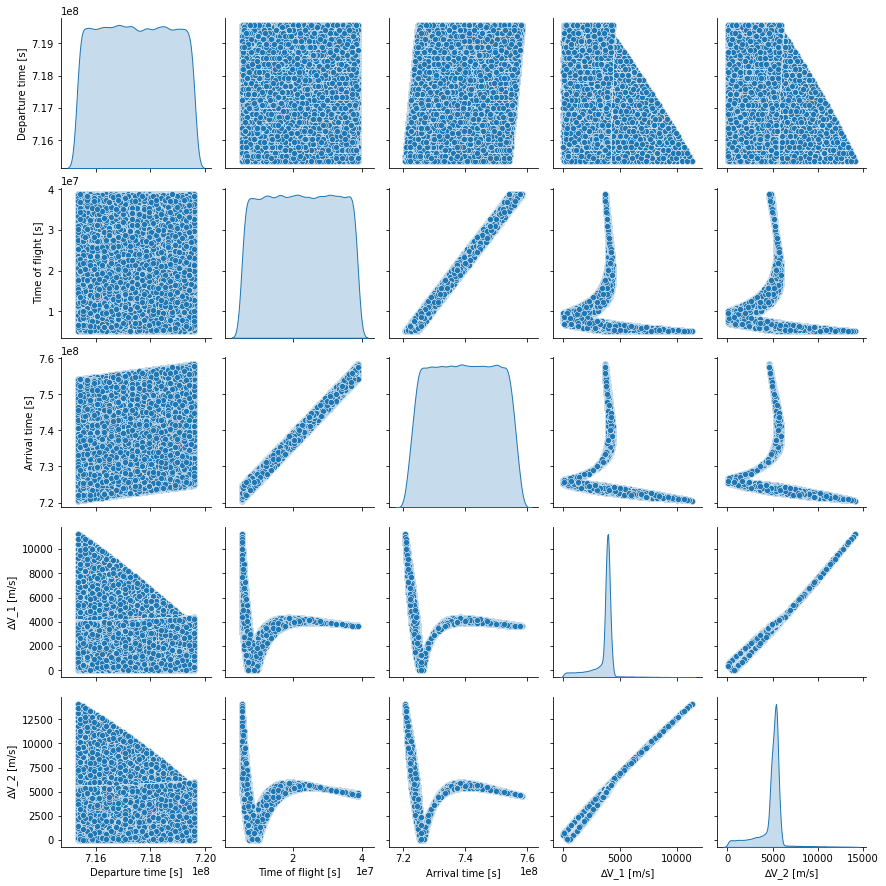

In [6]:
sns.pairplot(dataset, diag_kind="kde")

### Split Data Up

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Training Data

In [8]:
train_dataset

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
3582,718718400.0,6134400.0,724852800.0,2601.716879,4060.680540
60498,717508800.0,19699200.0,737208000.0,4001.013320,5432.500511
53227,715435200.0,30412800.0,745848000.0,3891.064349,5288.119148
21333,718977600.0,37756800.0,756734400.0,3683.638405,4687.861579
3885,718632000.0,36374400.0,755006400.0,3720.015338,4806.306987
...,...,...,...,...,...
27389,718632000.0,6566400.0,725198400.0,1784.465663,3004.672396
8871,716472000.0,16070400.0,732542400.0,3495.209976,4589.100579
47812,719496000.0,38707200.0,758203200.0,3674.561535,4590.883176
4539,716644800.0,20304000.0,736948800.0,3909.356236,5322.021656


In [9]:
train_dataset.describe()

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
count,8.000000e+04,8.000000e+04,8.000000e+04,80000.000000,80000.000000
mean,7.174556e+08,2.202729e+07,7.394829e+08,3551.582772,4737.753298
std,1.246090e+06,9.730054e+06,9.810521e+06,1108.856078,1524.673941
min,7.153488e+08,5.184000e+06,7.205328e+08,0.275321,2.204792
25%,7.163856e+08,1.356480e+07,7.310736e+08,3560.871874,4655.382076
50%,7.174224e+08,2.203200e+07,7.394544e+08,3840.149250,5134.456582
75%,7.185456e+08,3.049920e+07,7.479216e+08,3978.692978,5417.120730
max,7.195824e+08,3.879360e+07,7.583760e+08,11256.830967,14123.314076


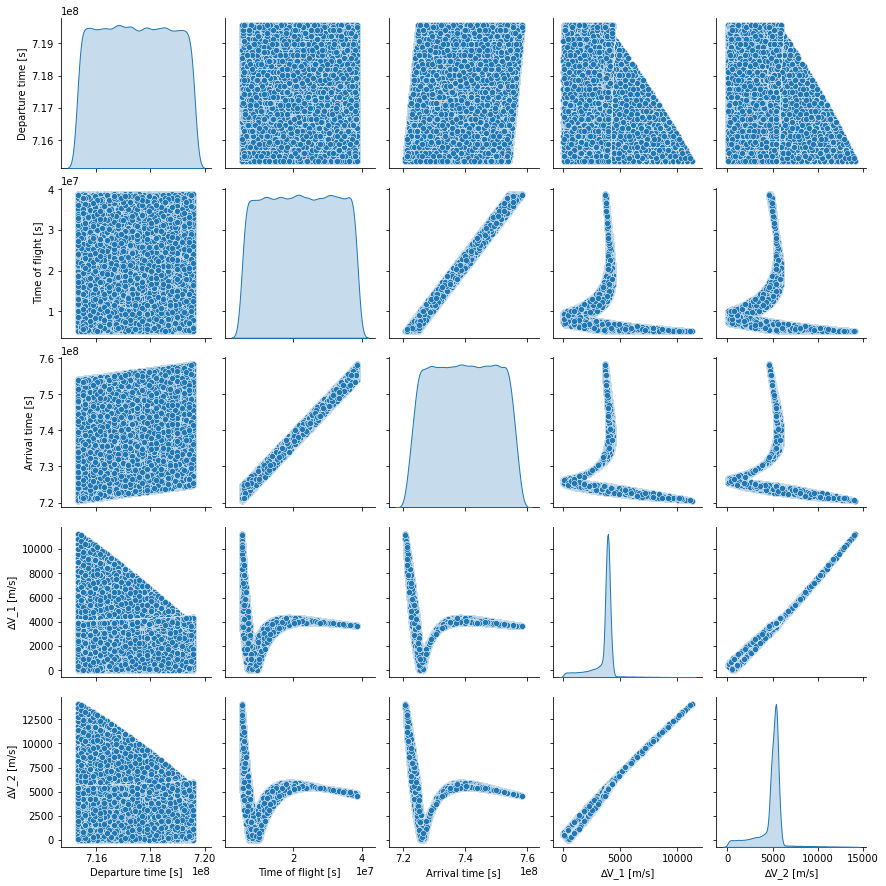

In [10]:
sns.pairplot(train_dataset, diag_kind="kde")

## Normalisation

In [11]:
def normalise_dataset(dataset):
    for i, the_range in zip(column_names, [departure_range, time_of_flight_range, arrival_range]):
        dataset[i] = (dataset[i] - the_range.min()) / (the_range.max() - the_range.min())

    for column in column_names[3:]:
        column_stats = dataset[column].describe()
        dataset[column] = (dataset[column] - column_stats.loc['mean']) / column_stats.loc['std']

    return dataset

train_data_normalised = normalise_dataset(train_dataset.copy())

In [12]:
train_data_normalised

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
3582,0.795918,0.028278,0.114155,-0.856618,-0.444077
60498,0.510204,0.431877,0.440639,0.405310,0.455669
53227,0.020408,0.750643,0.668950,0.306155,0.360973
21333,0.857143,0.969152,0.956621,0.119092,-0.032723
3885,0.775510,0.928021,0.910959,0.151898,0.044963
...,...,...,...,...,...
27389,0.775510,0.041131,0.123288,-1.593640,-1.136690
8871,0.265306,0.323907,0.317352,-0.050839,-0.097498
47812,0.979592,0.997429,0.995434,0.110906,-0.096329
4539,0.306122,0.449871,0.433790,0.322651,0.383209


In [13]:
train_data_normalised.describe()

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
count,80000.000000,80000.000000,80000.000000,8.000000e+04,8.000000e+04
mean,0.497639,0.501145,0.500753,-3.387512e-16,-8.352430e-16
std,0.294333,0.289502,0.259241,1.000000e+00,1.000000e+00
min,0.000000,0.000000,0.000000,-3.202677e+00,-3.105942e+00
25%,0.244898,0.249357,0.278539,8.377194e-03,-5.402547e-02
50%,0.489796,0.501285,0.500000,2.602380e-01,2.601889e-01
75%,0.755102,0.753213,0.723744,3.851809e-01,4.455821e-01
max,1.000000,1.000000,1.000000,6.948826e+00,6.155782e+00


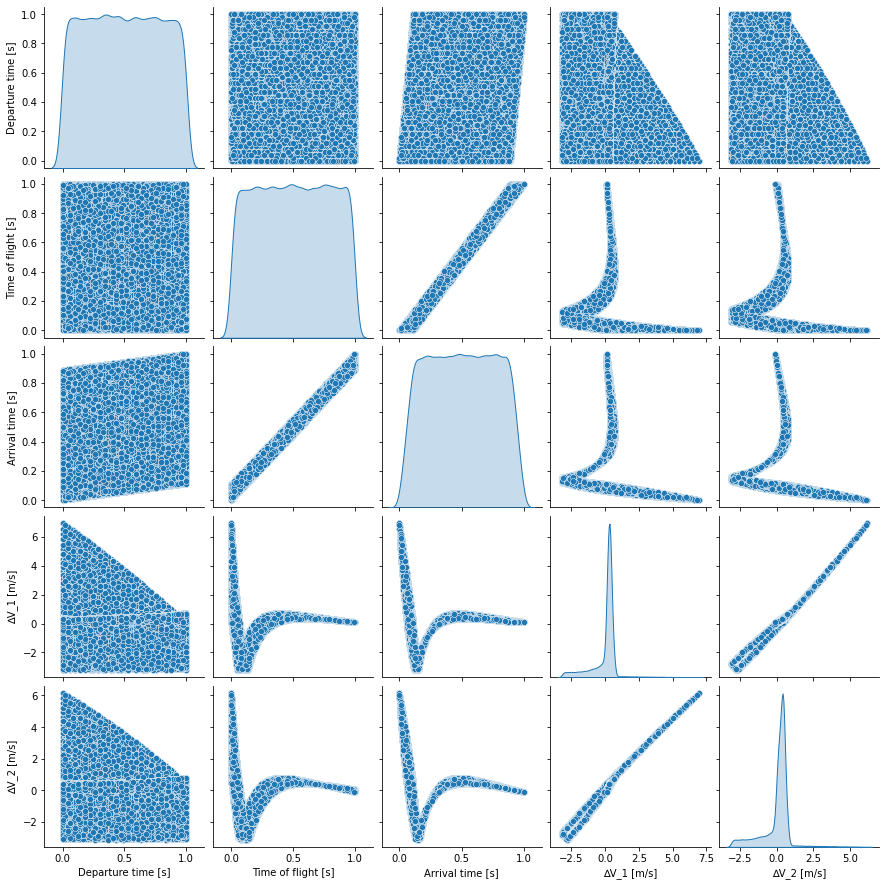

In [14]:
sns.pairplot(train_data_normalised, diag_kind="kde")

### Training data

In [15]:
train_data_normalised

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
3582,0.795918,0.028278,0.114155,-0.856618,-0.444077
60498,0.510204,0.431877,0.440639,0.405310,0.455669
53227,0.020408,0.750643,0.668950,0.306155,0.360973
21333,0.857143,0.969152,0.956621,0.119092,-0.032723
3885,0.775510,0.928021,0.910959,0.151898,0.044963
...,...,...,...,...,...
27389,0.775510,0.041131,0.123288,-1.593640,-1.136690
8871,0.265306,0.323907,0.317352,-0.050839,-0.097498
47812,0.979592,0.997429,0.995434,0.110906,-0.096329
4539,0.306122,0.449871,0.433790,0.322651,0.383209


In [16]:
train_data_normalised.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Departure time [s],80000.0,4.976385e-01,0.294333,0.000000,0.244898,0.489796,0.755102,1.000000
Time of flight [s],80000.0,5.011451e-01,0.289502,0.000000,0.249357,0.501285,0.753213,1.000000
Arrival time [s],80000.0,5.007529e-01,0.259241,0.000000,0.278539,0.500000,0.723744,1.000000
∆V_1 [m/s],80000.0,-3.387512e-16,1.000000,-3.202677,0.008377,0.260238,0.385181,6.948826
∆V_2 [m/s],80000.0,-8.352430e-16,1.000000,-3.105942,-0.054025,0.260189,0.445582,6.155782


## Model


In [17]:
model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=[2]),
    layers.Dense(100, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 10,602
Trainable params: 10,602
Non-trainable params: 0
_________________________________________________________________


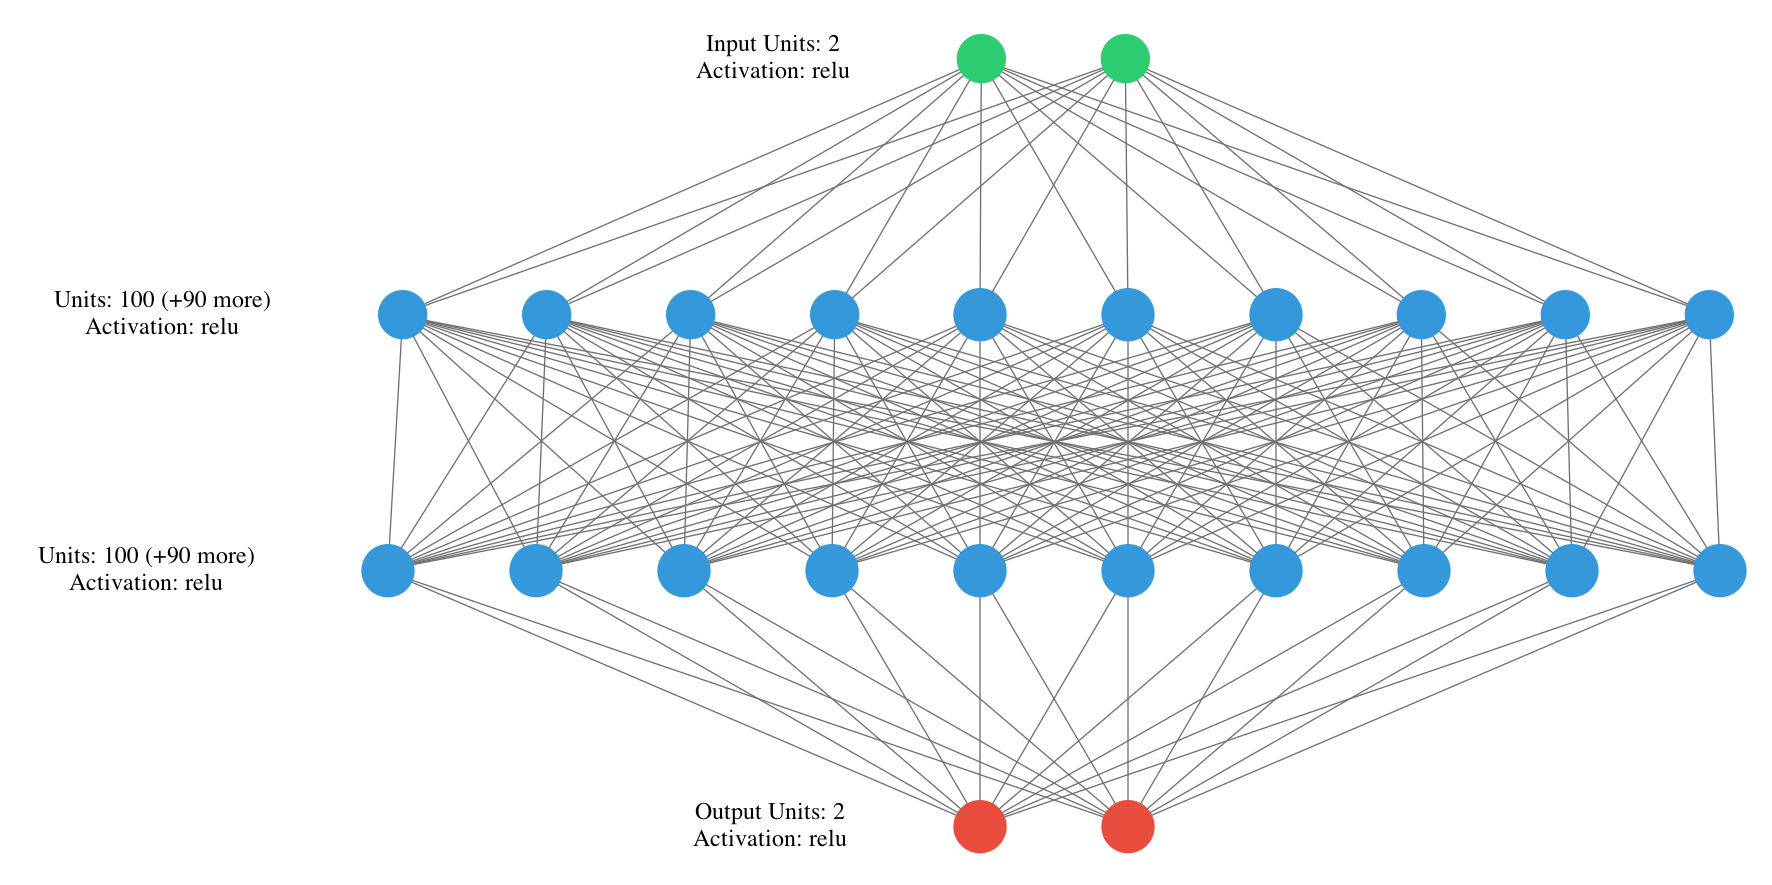

In [19]:
visualizer(model, format='png')
display((Image(filename='graph.png')))

In [20]:
%%time
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0005,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

history = model.fit(train_data_normalised[[column_names[0], column_names[1]]].to_numpy(),
                    train_data_normalised[[column_names[3], column_names[4]]].to_numpy(),
                    validation_split=0.2,
                    epochs=1000,
                    batch_size=5000,
                    callbacks=[early_stop])

Train on 64000 samples, validate on 16000 samples
Epoch 1/1000
64000/64000 [==============================] - 1s 18us/sample - loss: 0.9771 - accuracy: 0.5182 - val_loss: 0.9372 - val_accuracy: 0.5999
Epoch 2/1000
64000/64000 [==============================] - 0s 6us/sample - loss: 0.9250 - accuracy: 0.5129 - val_loss: 0.8976 - val_accuracy: 0.6039
Epoch 3/1000
64000/64000 [==============================] - 0s 4us/sample - loss: 0.8847 - accuracy: 0.5351 - val_loss: 0.8607 - val_accuracy: 0.5043
Epoch 4/1000
64000/64000 [==============================] - 0s 6us/sample - loss: 0.8483 - accuracy: 0.4642 - val_loss: 0.8294 - val_accuracy: 0.4209
Epoch 5/1000
64000/64000 [==============================] - 0s 5us/sample - loss: 0.8185 - accuracy: 0.4228 - val_loss: 0.8034 - val_accuracy: 0.3902
Epoch 6/1000
64000/64000 [==============================] - 0s 5us/sample - loss: 0.7917 - accuracy: 0.3616 - val_loss: 0.7771 - val_accuracy: 0.3574
Epoch 7/1000
64000/64000 [=======================

In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
111,0.000804,0.969719,0.000783,0.971375,111
112,0.000757,0.969922,0.000720,0.970625,112
113,0.000730,0.969969,0.000707,0.970688,113
114,0.000714,0.970047,0.000705,0.971375,114
115,0.000704,0.969922,0.000700,0.971375,115


In [22]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

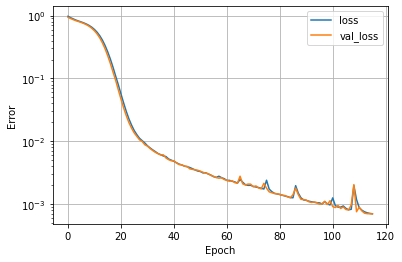

In [23]:
plot_loss(history)

In [24]:
test_dataset.describe()

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
count,2.000000e+04,2.000000e+04,2.000000e+04,20000.000000,20000.000000
mean,7.174662e+08,2.195818e+07,7.394244e+08,3537.214709,4719.757735
std,1.247691e+06,9.703677e+06,9.780584e+06,1112.304270,1528.735394
min,7.153488e+08,5.184000e+06,7.206192e+08,0.275321,2.204792
25%,7.163856e+08,1.356480e+07,7.310736e+08,3555.597075,4649.604908
50%,7.174224e+08,2.194560e+07,7.393680e+08,3837.964765,5132.809440
75%,7.185456e+08,3.032640e+07,7.478352e+08,3977.946219,5417.653352
max,7.195824e+08,3.879360e+07,7.583760e+08,11123.847199,13977.160247


In [25]:
test_data_normalised = normalise_dataset(test_dataset.copy())

In [26]:
test_data_normalised

,Departure time [s],Time of flight [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
2,0.428571,0.107969,0.143836,-3.045215,-2.824312
10,0.244898,0.791774,0.730594,0.271611,0.306349
13,0.346939,0.138817,0.162100,-2.310094,-2.599236
20,0.163265,0.483290,0.447489,0.320197,0.396240
21,0.734694,0.735219,0.735160,0.355233,0.367616
...,...,...,...,...,...
99966,0.040816,0.498715,0.447489,0.324865,0.388851
99971,0.510204,0.344473,0.363014,0.245300,0.231884
99973,0.102041,0.485861,0.442922,0.314344,0.384171
99977,0.469388,0.817481,0.778539,0.274929,0.254321


In [27]:
prediction = model.predict(test_data_normalised[[column_names[0], column_names[1]]].to_numpy())

In [28]:
pd.DataFrame(data=prediction, columns=[column_names[3], column_names[4]])

,∆V_1 [m/s],∆V_2 [m/s]
0,-3.036649,-2.921598
1,0.265910,0.296863
2,-2.338431,-2.614182
3,0.323284,0.384565
4,0.358648,0.357461
...,...,...
19995,0.311896,0.373141
19996,0.222917,0.225775
19997,0.313525,0.372013
19998,0.260577,0.246235


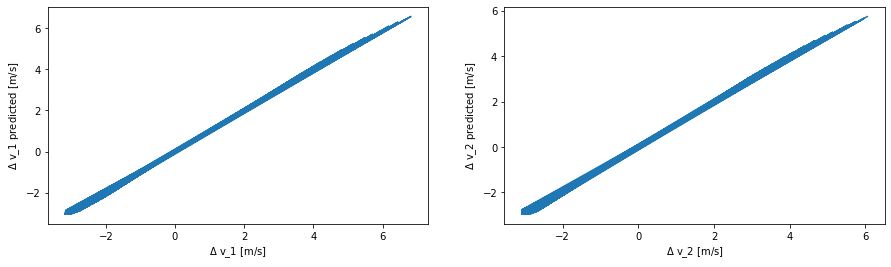

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.plot(test_data_normalised[column_names[3]], prediction[:, 0])
ax2.plot(test_data_normalised[column_names[4]], prediction[:, 1])

for i, ax in enumerate([ax1, ax2]):
    ax.set_ylabel(fr'$\Delta$ v_{i+1} predicted [m/s]')
    ax.set_xlabel(fr'$\Delta$ v_{i+1} [m/s]')

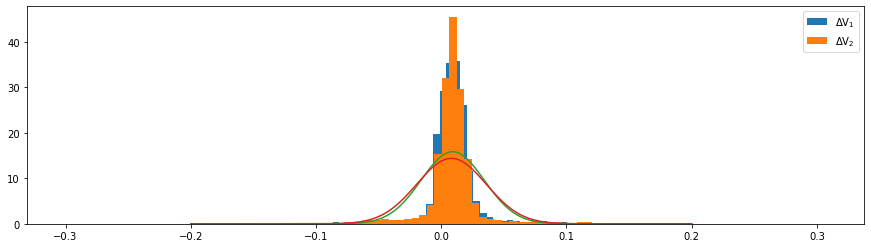

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 4))
from scipy.stats import norm

def plot_normal(data):
    mean = np.average(data)
    std = np.std(data)
    x = np.linspace(-0.2, 0.2, 1000)
    ax1.plot(x, norm.pdf(x, mean, std))

ax1.hist(test_data_normalised[column_names[3]] - prediction[:, 0], bins=101, label=rf"$\Delta$V$_1$", density=True)
ax1.hist(test_data_normalised[column_names[4]] - prediction[:, 1], bins=101, label=rf"$\Delta$V$_2$", density=True)
plot_normal(test_data_normalised[column_names[3]] - prediction[:, 0])
plot_normal(test_data_normalised[column_names[4]] - prediction[:, 1])
ax1.legend()